In [1]:
!git clone https://github.com/kishkath/CIFAR10-OCP.git

Cloning into 'CIFAR10-OCP'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 61 (delta 29), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), 18.31 KiB | 646.00 KiB/s, done.


In [2]:
import sys
sys.path.append("/content/CIFAR10-OCP/")

In [3]:
!pip install torchsummary
!pip install pytorch-gradcam
!pip install torch_lr_finder
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 56.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5267 sha256=eda1229fbcf2ab051fa45832ea024479a660bfa60cce0b4672e92d080dd940f7
  Stored in directory: /root/.cache/pip/wheels/dd/3c/0e/8b7512f5d7f462c9c37342107b7f0276609345f246ae4e75fc
Successfully built pytorch-gradcam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from colorama import Fore,Style
import matplotlib.pyplot as plt
# python pip Libraries


from models import model9
from main import Performance,scores
from torchsummary import summary
from utils import mis_prediction,loader

from utils import class_accuracy,Plot_curves, plotting_gradCams,Draw
# user defined libraries:
# models has resnet model.
# main.py has things related to training & testing accuracies,
  ## scores returns train_acc,loss,test_acc,loss
# utils.py contain dataloading substance(loader)
  ## Plotting train-test performances and mis-classifications
  ## Plotting GRAD-CAM, deriving class wise accuracy, 
  ## getting mis-classifying list to verify if we need

==> Preparing data..
==> Getting model..
==> Its Training!


In [5]:
trainloader,testloader = loader.load_data(512)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
## CIFAR10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
import torch.nn.functional as F
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = model9.Transformer().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
            Conv2d-2           [-1, 32, 28, 28]           4,640
            Conv2d-3           [-1, 48, 26, 26]          13,872
 AdaptiveAvgPool2d-4             [-1, 48, 1, 1]               0
            Linear-5                    [-1, 8]             392
            Linear-6                    [-1, 8]             392
            Linear-7                    [-1, 8]             392
           Softmax-8                    [-1, 8]               0
            Linear-9                   [-1, 48]             432
          ULTIMUS-10                   [-1, 48]               0
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
          Softmax-14                   

In [9]:
from copy import deepcopy 
model1 = deepcopy(model)
model2 = deepcopy(model)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.78E-02


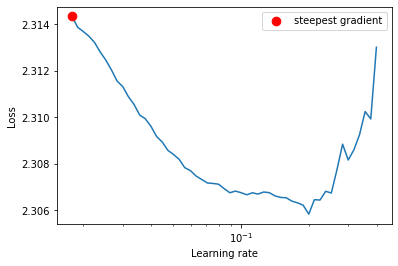

0.2000387787090401


In [10]:
from torch_lr_finder import LRFinder
import numpy as np
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01,weight_decay=0.01)

# Instantiate the LRFinder object
lr_finder = LRFinder(model2, optimizer,criterion,device="cuda")

# Run the range test
lr_finder.range_test(trainloader, end_lr=3, num_iter=100,step_mode='exp')

# Plot the learning rate versus loss curve
lr_finder.plot()

min_loss = min(lr_finder.history['loss'])
max_loss = min(lr_finder.history['loss'])
# Identify the optimal learning rate
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print(ler_rate)

In [ ]:
import torch.optim as optim
device = "cuda"
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.Adam(model1.parameters(),lr=0.003)
criterion = nn.CrossEntropyLoss()
# Define your learning rate scheduler using the OneCycleLR class
scheduler = OneCycleLR(optimizer,div_factor=10,max_lr=0.2, epochs=20, steps_per_epoch=len(trainloader), pct_start=0.25, anneal_strategy='linear', three_phase=False,cycle_momentum=False)

# Train your neural network using the one-cycle learning rate policy
for epoch in range(20):
    print("EPOCH:", epoch)
    for p in optimizer.param_groups:
        print("Current Learning Rate: ",p["lr"])
    Performance().train(model1,device, trainloader, optimizer, epoch,criterion,[False,0.001],scheduler=scheduler)
    for p in optimizer.param_groups:
        print("updated Learning Rate: ",p["lr"])
    Performance().test(model1,device, testloader,epoch,criterion)


EPOCH: 0
Current Learning Rate:  0.02


Loss=113335.453125 Batch_id=97 train-Accuracy=9.93: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


updated Learning Rate:  0.05607361963190184

Test set: Average loss: 183.4874, val-Accuracy: 1247/10000 (12.47%)

Saving..
EPOCH: 1
Current Learning Rate:  0.05607361963190184


Loss=38317688.0 Batch_id=97 train-Accuracy=10.08: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]


updated Learning Rate:  0.09214723926380369

Test set: Average loss: 24041.3675, val-Accuracy: 1285/10000 (12.85%)

Saving..
EPOCH: 2
Current Learning Rate:  0.09214723926380369


Loss=154590452383744.0 Batch_id=97 train-Accuracy=10.09: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]


updated Learning Rate:  0.12822085889570553

Test set: Average loss: 14943963001.6512, val-Accuracy: 955/10000 (9.55%)

EPOCH: 3
Current Learning Rate:  0.12822085889570553


Loss=381712760832.0 Batch_id=97 train-Accuracy=9.77: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]


updated Learning Rate:  0.16429447852760737

Test set: Average loss: 1904415814.4512, val-Accuracy: 874/10000 (8.74%)

EPOCH: 4
Current Learning Rate:  0.16429447852760737


Loss=63459614720.0 Batch_id=97 train-Accuracy=10.03: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]


updated Learning Rate:  0.19986394693877552

Test set: Average loss: 159926392.4224, val-Accuracy: 939/10000 (9.39%)

EPOCH: 5
Current Learning Rate:  0.19986394693877552


Loss=7664241664.0 Batch_id=97 train-Accuracy=9.28: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]


updated Learning Rate:  0.18653074693877553

Test set: Average loss: 18677243.1360, val-Accuracy: 978/10000 (9.78%)

EPOCH: 6
Current Learning Rate:  0.18653074693877553


Loss=84368024.0 Batch_id=97 train-Accuracy=11.43: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]


updated Learning Rate:  0.17319754693877554

Test set: Average loss: 180797.7928, val-Accuracy: 1208/10000 (12.08%)

EPOCH: 7
Current Learning Rate:  0.17319754693877554


Loss=26844796.0 Batch_id=97 train-Accuracy=12.91: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]


updated Learning Rate:  0.15986434693877552

Test set: Average loss: 99193.4488, val-Accuracy: 1269/10000 (12.69%)

EPOCH: 8
Current Learning Rate:  0.15986434693877552


Loss=171715248.0 Batch_id=97 train-Accuracy=9.97: 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]


updated Learning Rate:  0.14653114693877553

Test set: Average loss: 88087.7356, val-Accuracy: 1033/10000 (10.33%)

EPOCH: 9
Current Learning Rate:  0.14653114693877553


Loss=12304755.0 Batch_id=97 train-Accuracy=9.86: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]


updated Learning Rate:  0.1331979469387755

Test set: Average loss: 61087.4043, val-Accuracy: 922/10000 (9.22%)

EPOCH: 10
Current Learning Rate:  0.1331979469387755


Loss=50186988.0 Batch_id=97 train-Accuracy=8.97: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s]


updated Learning Rate:  0.11986474693877551

Test set: Average loss: 95983.1736, val-Accuracy: 887/10000 (8.87%)

EPOCH: 11
Current Learning Rate:  0.11986474693877551


Loss=7402229.5 Batch_id=97 train-Accuracy=9.64: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]


updated Learning Rate:  0.10653154693877552

Test set: Average loss: 38481.8075, val-Accuracy: 948/10000 (9.48%)

EPOCH: 12
Current Learning Rate:  0.10653154693877552


Loss=1469058048.0 Batch_id=97 train-Accuracy=10.74: 100%|██████████| 98/98 [00:15<00:00,  6.29it/s]


updated Learning Rate:  0.0931983469387755

Test set: Average loss: 1103996.5088, val-Accuracy: 1111/10000 (11.11%)

EPOCH: 13
Current Learning Rate:  0.0931983469387755


Loss=27770992.0 Batch_id=97 train-Accuracy=9.42: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]


updated Learning Rate:  0.07986514693877551

Test set: Average loss: 37448.9450, val-Accuracy: 969/10000 (9.69%)

EPOCH: 14
Current Learning Rate:  0.07986514693877551


Loss=4194500.5 Batch_id=97 train-Accuracy=10.77: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]


updated Learning Rate:  0.06653194693877551

Test set: Average loss: 40093.1347, val-Accuracy: 1155/10000 (11.55%)

EPOCH: 15
Current Learning Rate:  0.06653194693877551


Loss=5103215.0 Batch_id=97 train-Accuracy=12.47: 100%|██████████| 98/98 [00:14<00:00,  6.87it/s]


updated Learning Rate:  0.05319874693877552

Test set: Average loss: 9951.0680, val-Accuracy: 1236/10000 (12.36%)

EPOCH: 16
Current Learning Rate:  0.05319874693877552


Loss=5001790.5 Batch_id=97 train-Accuracy=9.85: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s]


updated Learning Rate:  0.03986554693877553

Test set: Average loss: 151905.5721, val-Accuracy: 862/10000 (8.62%)

EPOCH: 17
Current Learning Rate:  0.03986554693877553


Loss=4355717.5 Batch_id=97 train-Accuracy=11.84: 100%|██████████| 98/98 [00:14<00:00,  6.83it/s]


updated Learning Rate:  0.026532346938775514

Test set: Average loss: 163821.4737, val-Accuracy: 1014/10000 (10.14%)

EPOCH: 18
Current Learning Rate:  0.026532346938775514


Loss=4779363.0 Batch_id=97 train-Accuracy=10.85: 100%|██████████| 98/98 [00:15<00:00,  6.53it/s]


updated Learning Rate:  0.013199146938775524

Test set: Average loss: 70469.9752, val-Accuracy: 817/10000 (8.17%)

EPOCH: 19
Current Learning Rate:  0.013199146938775524


Loss=7708151.0 Batch_id=97 train-Accuracy=9.88: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


array([[<Axes: title={'center': 'Training Loss'}>,
        <Axes: title={'center': 'Test Loss'}>],
       [<Axes: title={'center': 'Training Accuracy'}>,
        <Axes: title={'center': 'Test Accuracy'}>]], dtype=object)

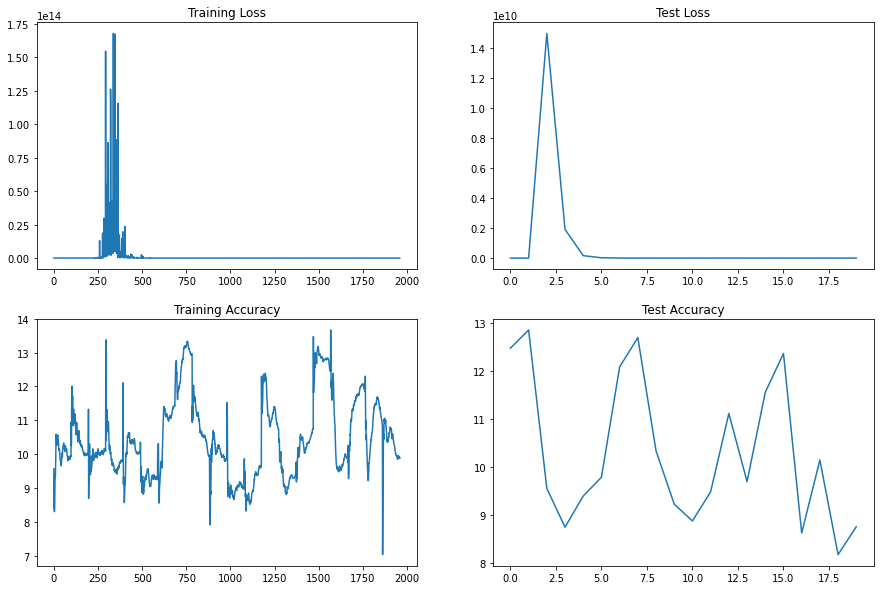

In [12]:
## Performance scores
train_acc,train_losses,test_acc,test_losses = scores()
Plot_curves().performance_curves(train_acc,test_acc,train_losses,test_losses)

                              MISCLASSIFIED IMAGES                              




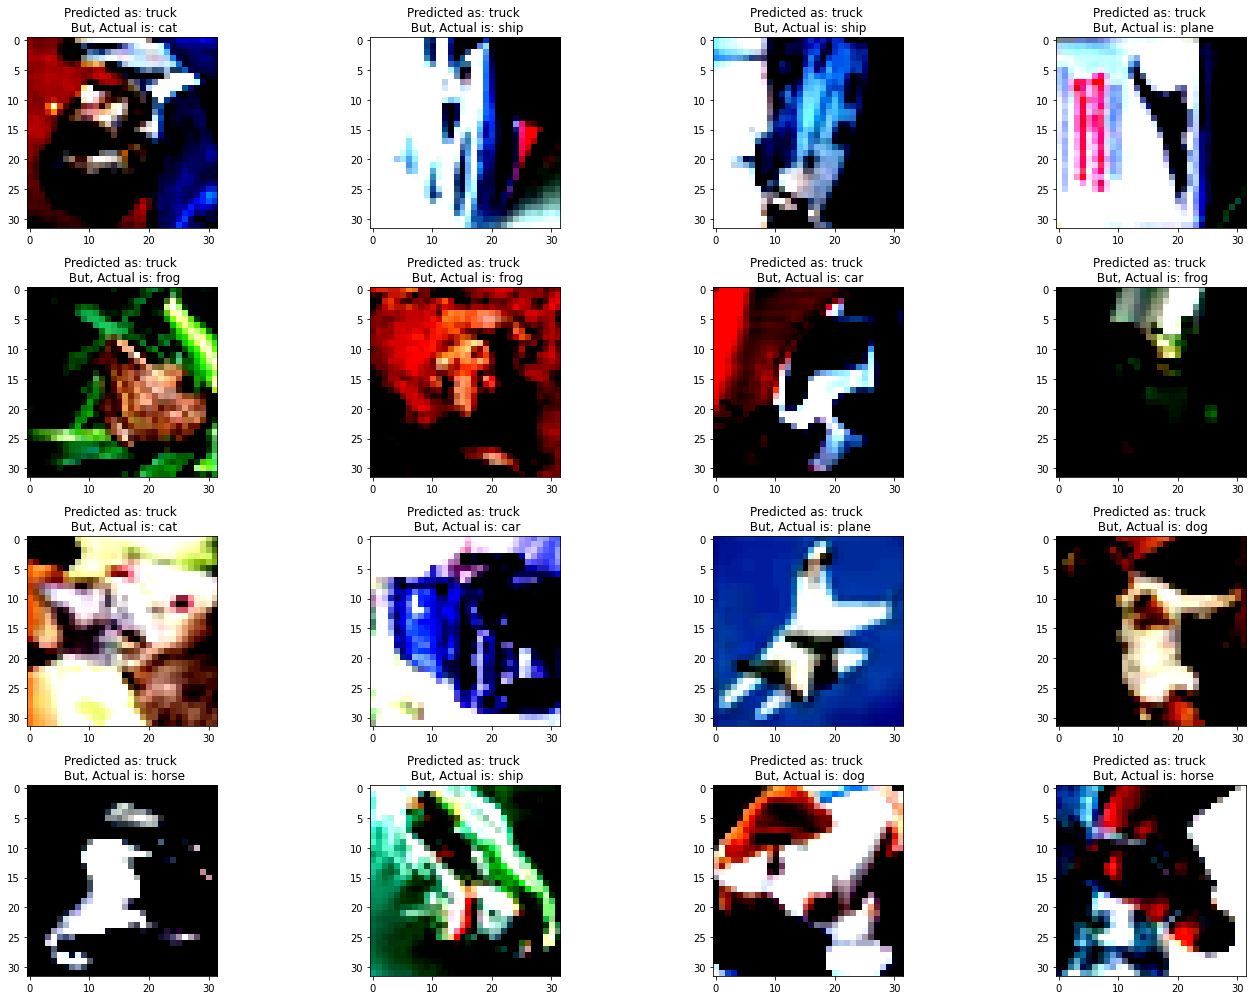

In [13]:
print(" "*30+Style.BRIGHT+Fore.BLACK+"MISCLASSIFIED IMAGES"+" "*30)
print("\n")
# If you want n number of images to plot just pass the number as third parameter:
# like: mis_classsified(model,testloader,7,default is 10
Plot_curves.mis_classified(model,testloader,16)

                    GRAD-CAM usable diagnosistic IMAGES                    
Diagnosis is happening for Layer2 of ResNet18. Lets go!


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


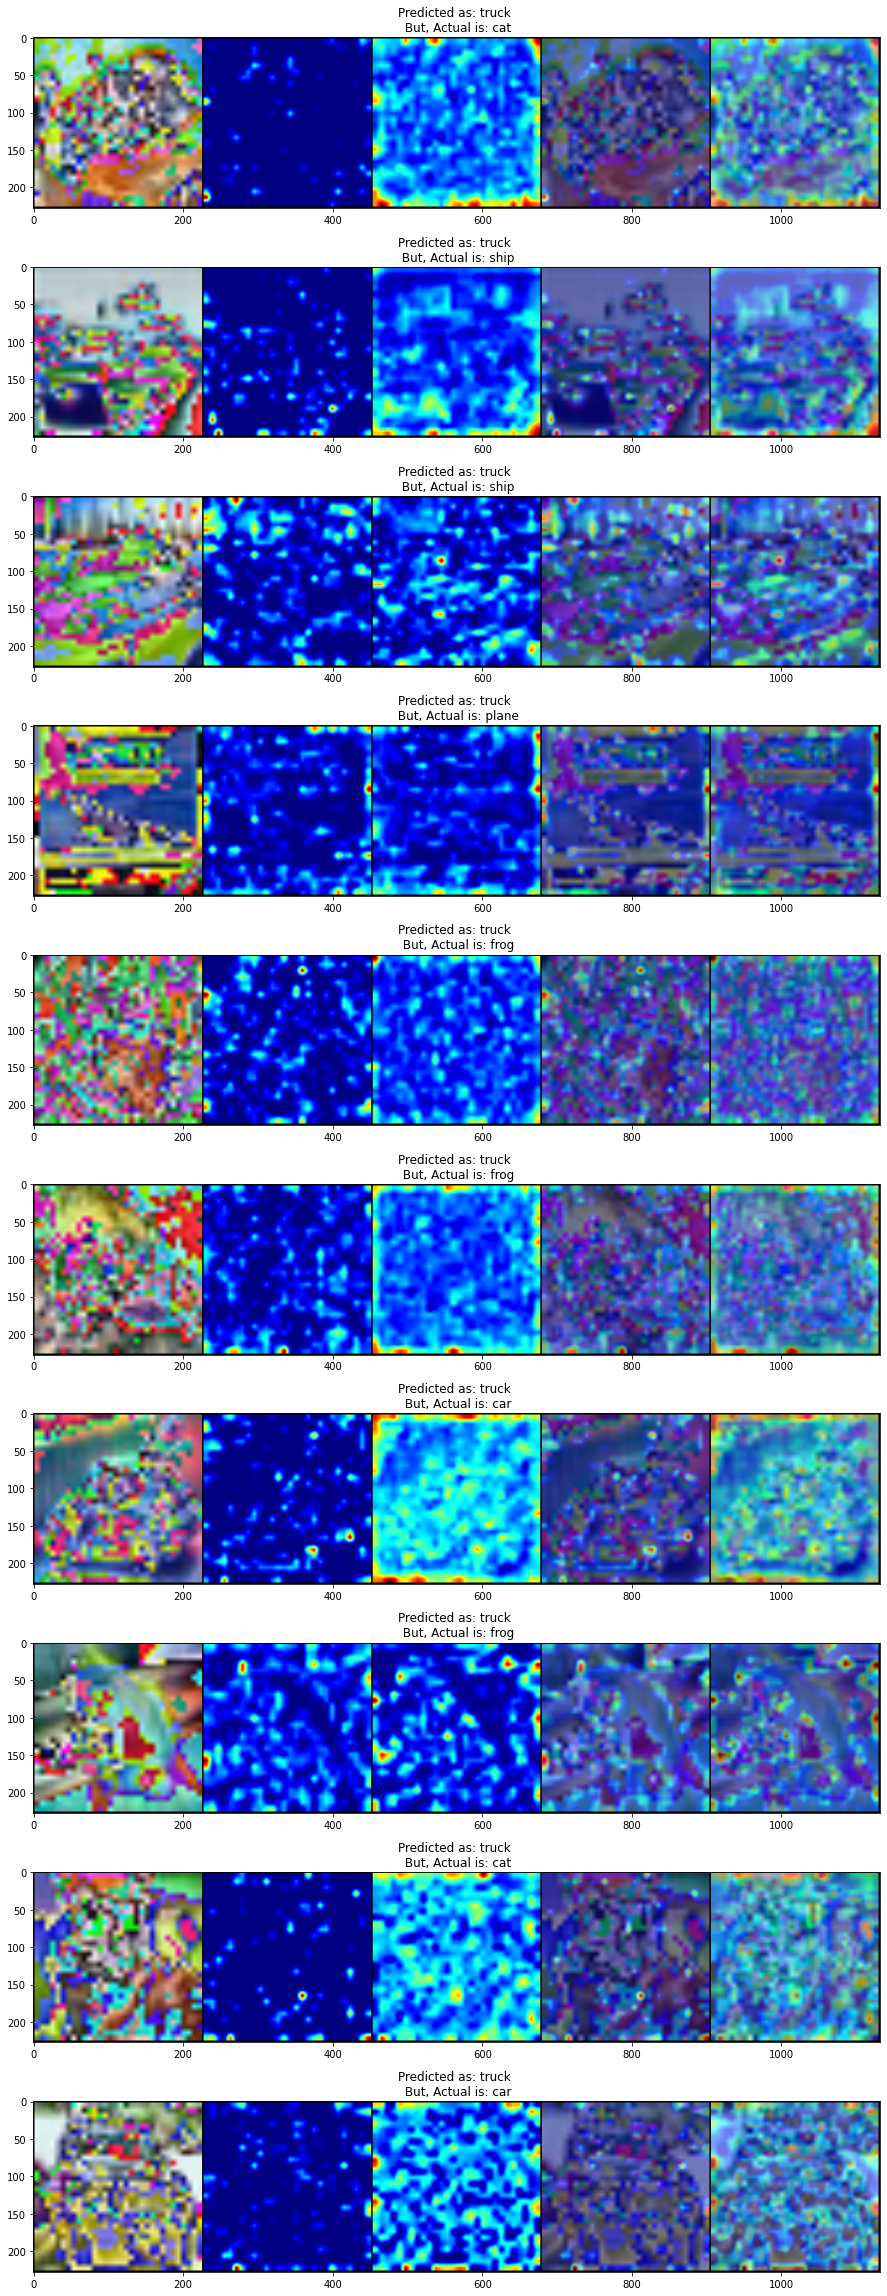

In [14]:
## Can plots any number of images less than stored mis-classifed Images
print(" "*20+Style.BRIGHT+Fore.BLACK+"GRAD-CAM usable diagnosistic IMAGES"+" "*20)
plotting_gradCams(10)

In [18]:
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_accuracies = class_accuracy.rate(testloader,model,classes)
for label,acc in class_accuracies.items():

  print(label,":",round(acc,2))

plane : 0.0
car : 0.0
bird : 0.0
cat : 0.0
deer : 0.0
dog : 0.0
frog : 0.0
horse : 0.0
ship : 0.0
truck : 100.0


In [19]:
print("Done, Not the best performing Architecture!")

Done, Not the best performing Architecture!
